In [1]:
import numpy as np
import pandas as pd

In [2]:
figsize=(10,7)

In [3]:
service_state1 = pd.read_csv('../dataset/captures/service_state_1.csv', header=None)
service_state2 = pd.read_csv('../dataset/captures/service_state_2.csv', header=None)

In [4]:
service_state1.columns = ['tick', 'team', 'service' ,'status']
service_state2.columns = ['tick', 'team', 'service' ,'status']

In [5]:
ordered_data1 = pd.pivot_table(service_state1, values = 'status', index=['tick', 'team'], columns='service',aggfunc=(lambda x: x.iloc[0]))
ordered_data2 = pd.pivot_table(service_state2, values = 'status', index=['tick', 'team'], columns='service',aggfunc=(lambda x: x.iloc[0]))

In [6]:
ordered_data1 = ordered_data1.replace(to_replace=' down',value=False)
ordered_data1 = ordered_data1.replace(to_replace=' up',value=True)

In [7]:
ordered_data2 = ordered_data2.replace(' down', False)
ordered_data2 = ordered_data2.replace(' up', True)

In [8]:
ordered_data1.head()

service    10001  10002  10003  10004  10005  10006  10007  10008  10009  \
tick team                                                                  
0    1     False  False  False  False  False  False  False  False  False   
     2     False  False  False  False  False  False  False  False  False   
     3     False  False  False  False  False  False  False  False  False   
     4     False  False  False  False  False  False  False  False  False   
     5     False  False  False  False  False  False  False  False  False   

service    10010  10011  10012  
tick team                       
0    1     False  False  False  
     2     False  False  False  
     3     False  False  False  
     4     False  False  False  
     5     False  False  False

In [9]:
captures1 = pd.read_csv('../dataset/captures/captures_1.csv.gz', header=None)
captures2 = pd.read_csv('../dataset/captures/captures_2.csv.gz', header=None)

In [10]:
#tmp = pd.pivot_table(captures1,val)
captures1.columns = ['tick','flag_captured','service','flag_lost']
captures2.columns = ['tick','flag_captured','service','flag_lost']
def aggregate_captures(data, index_name, values, index ):
    tmp = pd.pivot_table(data, values=values, index=index, columns='service',aggfunc=len).fillna(0).pivot_table(index = index[-1],aggfunc=sum)
    tmp.index.names = [index_name]
    return tmp
flag_captured_1 = aggregate_captures(captures1,'team', 'flag_lost',['tick', 'flag_captured'])
flag_lost_1 = aggregate_captures(captures1,'team', 'flag_captured',['tick', 'flag_lost'])
flag_captured_2 = aggregate_captures(captures2,'team', 'flag_lost',['tick', 'flag_captured'])
flag_lost_2 = aggregate_captures(captures2,'team', 'flag_captured',['tick', 'flag_lost'])

In [11]:
#Team Uptime/service  Flags in/service Flagsout/service
uptime_data1 = ordered_data1.replace(True, 1).replace(False, 0)
uptime_data2 = ordered_data2.replace(True, 1).replace(False, 0)
sla_round_1 = pd.pivot_table(uptime_data1,index='team')
sla_round_2 = pd.pivot_table(uptime_data2,index='team')

In [12]:
# Rename Col's
flag_captured_1.columns = flag_captured_1.columns.map(lambda col: 'captured_' + str(col))
flag_captured_2.columns = flag_captured_2.columns.map(lambda col: 'captured_' + str(col))
flag_lost_1.columns = flag_lost_1.columns.map(lambda col: 'lost_' + str(col))
flag_lost_2.columns = flag_lost_2.columns.map(lambda col: 'lost_' + str(col))
sla_round_1.columns = sla_round_1.columns.map(lambda col: 'sla_' + str(col))
sla_round_2.columns = sla_round_2.columns.map(lambda col: 'sla_' + str(col))
sla_round_1.head()

service,sla_10001,sla_10002,sla_10003,sla_10004,sla_10005,sla_10006,sla_10007,sla_10008,sla_10009,sla_10010,sla_10011,sla_10012
team,,,,,,,,,,,,
1,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.788889,0.966667,0.966667,0.966667
2,0.966667,0.655556,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.788889,0.966667,0.966667,0.966667
3,0.966667,0.677778,0.966667,0.966667,0.966667,0.955556,0.966667,0.966667,0.800000,0.966667,0.966667,0.966667
4,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.955556,0.955556,0.766667,0.944444,0.933333,0.933333
5,0.966667,0.677778,0.966667,0.966667,0.966667,0.966667,0.966667,0.966667,0.877778,0.966667,0.966667,0.966667


In [13]:
features_1 = pd.concat([sla_round_1,flag_captured_1,flag_lost_1],axis=1).fillna(0)
features_2 = pd.concat([sla_round_2,flag_captured_2,flag_lost_2],axis=1).fillna(0)

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
features1_embedded = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(features_1)

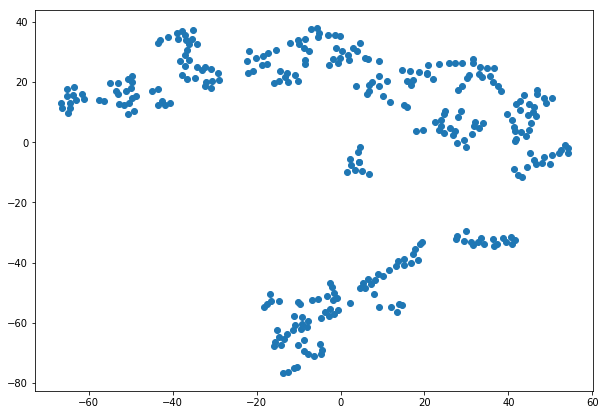

In [15]:
plt.figure(figsize=figsize)
plt.scatter(features1_embedded[:,0],features1_embedded[:,1])
plt.show()

In [16]:
from sklearn.preprocessing import normalize, scale
features1_scaled = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(scale(features_1))
features1_norm = TSNE(n_components=2, perplexity=10,n_iter=2000).fit_transform(normalize(features_1))

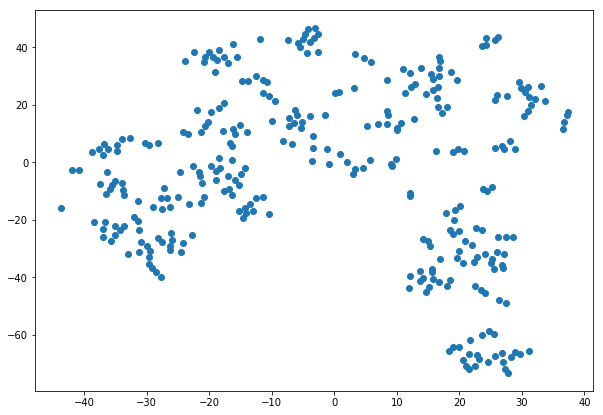

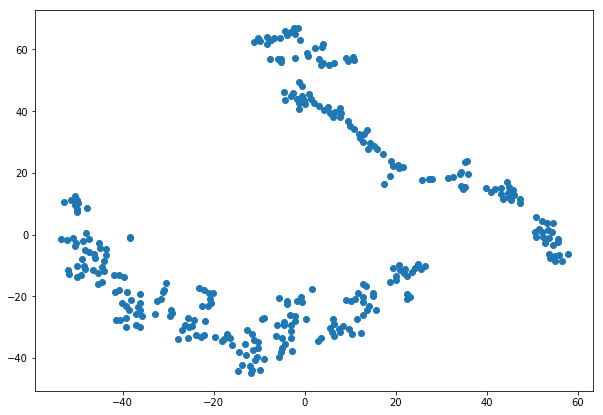

In [17]:
plt.figure(figsize=figsize)
plt.scatter(features1_scaled[:,0],features1_scaled[:,1])
plt.show()
plt.figure(figsize=figsize)
plt.scatter(features1_norm[:,0],features1_norm[:,1])
plt.show()

In [18]:
features_s = scale(features_1)
features_n = normalize(features_1)
features = features_1
fs = [features, features_s, features_n]

new Dataset


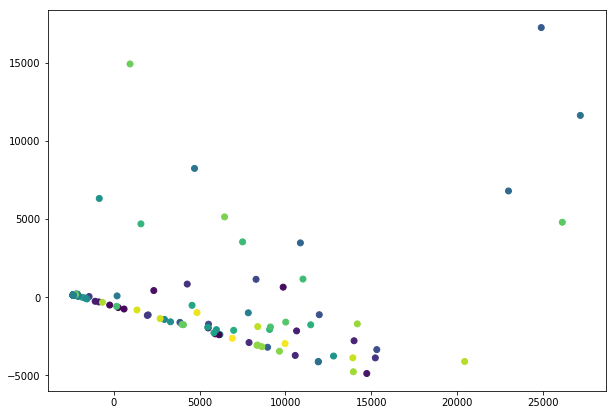

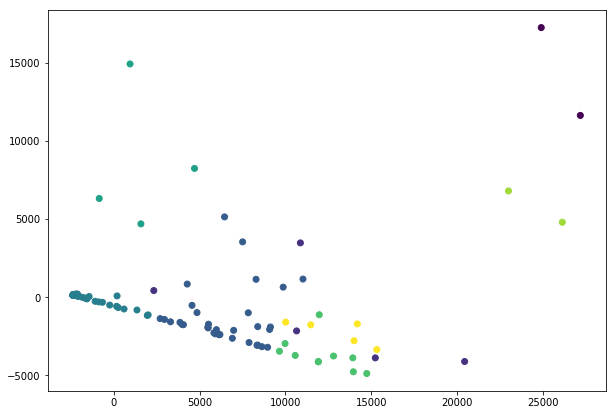

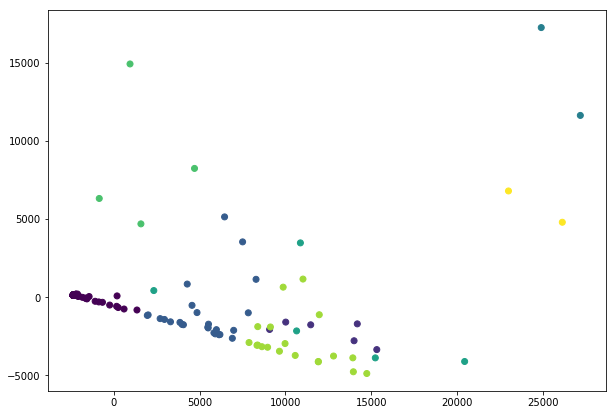

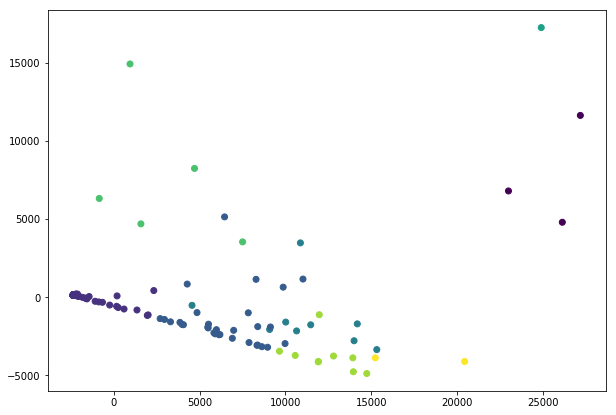

new Dataset


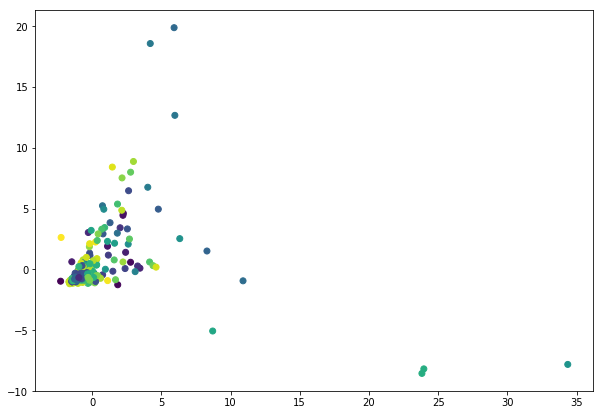

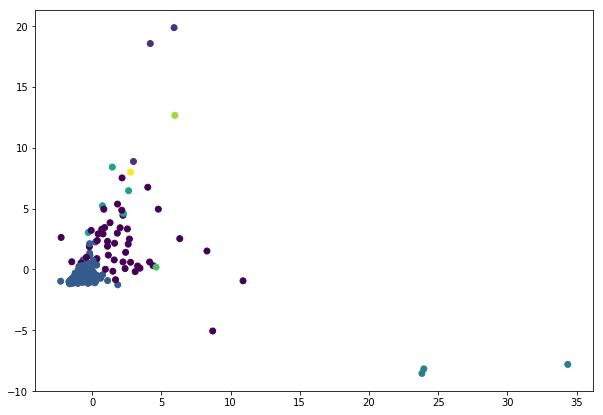

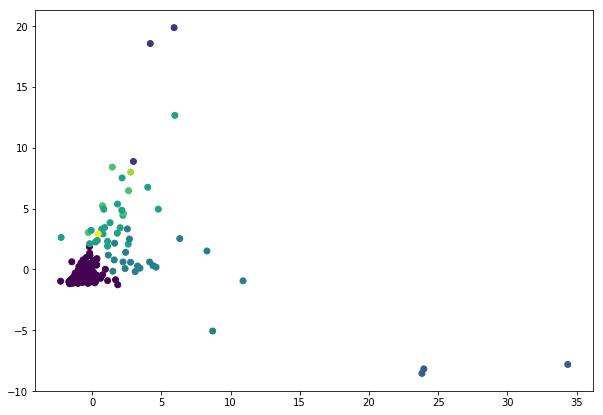

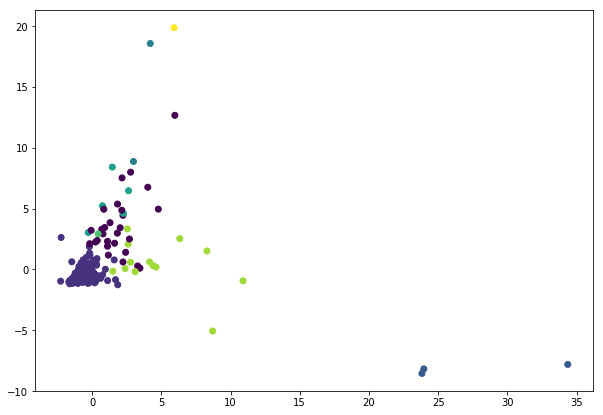

new Dataset


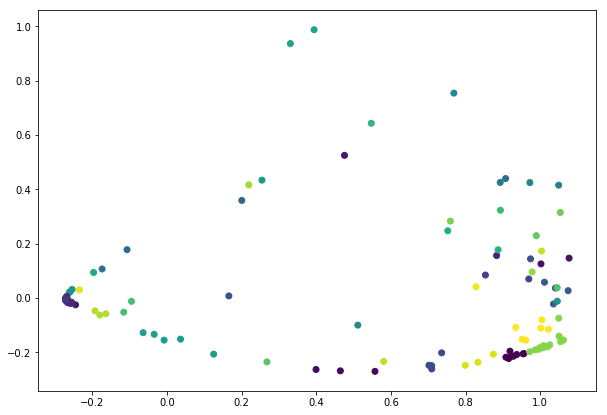

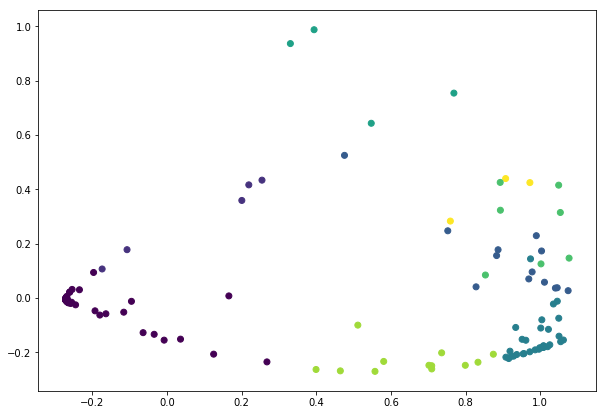

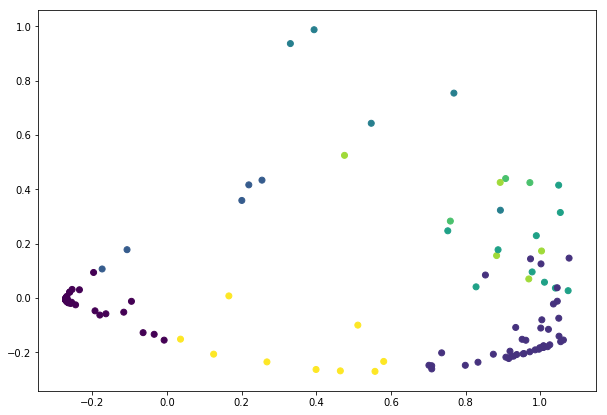

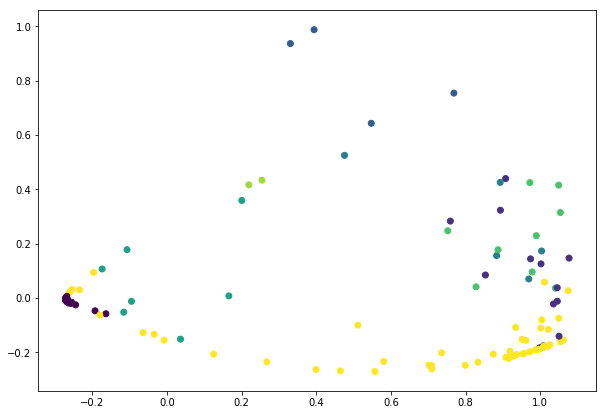

In [19]:
from sklearn.cluster import AffinityPropagation,AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

clusterers = [AffinityPropagation(),AgglomerativeClustering(n_clusters=8),KMeans(),GaussianMixture(n_components=8)]
for dataset in fs:
    print('new Dataset')
    pc = PCA(n_components=2)
    trans = pc.fit_transform(dataset)
    for cl in clusterers:
        if('fit_predict' in dir(cl)):
            labels = cl.fit_predict(dataset)
        else:
            cl.fit(dataset)
            labels = cl.predict(dataset)
        plt.figure(figsize=figsize)
        plt.scatter(trans[:,0],trans[:,1],c=labels)
        plt.show()
        labels = np.array(labels)
        #for group in np.unique(labels):
            #df = pd.DataFrame(dataset[labels ==group])
            #print(df.describe())
        